# Dataset Generation using Emulator

Start the emulator and save a screenshot containing the screen of the emulated device exactly.
Save the path to the screenshot in the variable below:

In [23]:
take_screenshot = False
use_android_screenshot = True
# TODO use_camera?

screenshot = 'AndroidScreenshot.png'

Run the cell below and check if the output matches the screen of the emulated device.

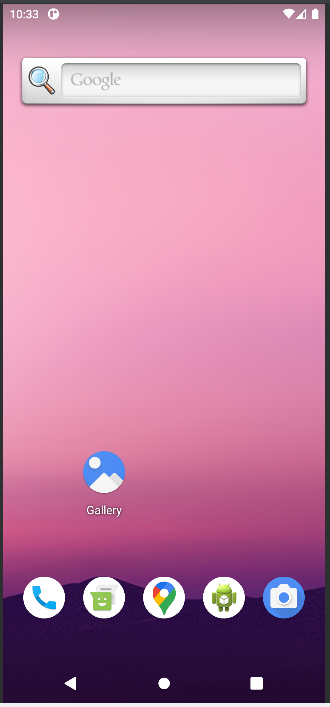

In [3]:
import pyautogui

box = pyautogui.locateOnScreen(screenshot, grayscale=True)

location = [box.left, box.top, box.width, box.height]

im = pyautogui.screenshot(region=location)
display(im)

Use the next cell to adjust the screenshot location and size if necessary.

[4100, 195, 330, 707]


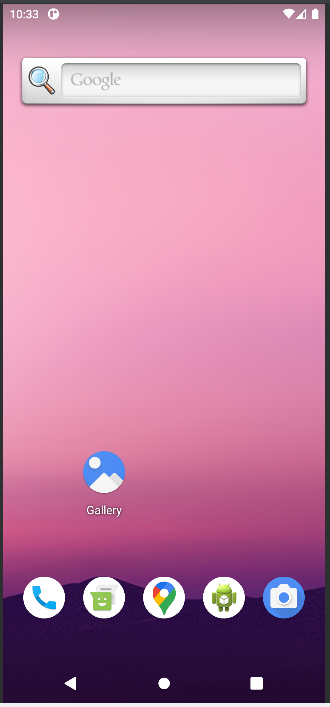

In [4]:
# location[0] = 880

im = pyautogui.screenshot(region=location)
print(location)
display(im)

Configure the parameters in the next cell before starting the dataset collection.

In [33]:
# Number of elements that will be collected.
DATASET_SIZE = 3
# Path of directory at which the dataset will be saved.
DATASET_PATH = "dataset/"
# IP adress of this computer.
HOST = "192.168.1.100"
# Port on which the server will listen.
PORT = 1281

Now, run the cell below. It will start a server, which the android application can then connect to and upload it's data. Thus, you can start the android application after starting the next cell. The dataset collection will happen automatically.

In [34]:
import json
import socketserver
import os
import base64
from io import BytesIO
from PIL import Image
from IPython.display import clear_output
import time

class Dataset:
    def __init__(self, size, path):
        self.total_size = size
        self.current_size = 0
        self.path = path
        # TODO: check path for validity and if dir is empty.
        
    def captureAndSaveImage(self, path: str):
        if take_screenshot:
            im = pyautogui.screenshot(path, region=location)
            # display(im)
        
    def saveAnnotations(self, path: str, data):
        
        data.pop("-1", None)
        for id_of_element, interactive_element in data.items():
            data.get(id_of_element).pop("mask", None)
        try:
            with open(path, "w") as file:
                file.write(json.dumps(data, indent=2))
        except Exception as e:
            print(e.message, e.args)
        
    def saveMasks(self, data):
        data = json.loads(data)
        for id_of_element, interactive_element in data.items():
            mask_bytes = base64.b64decode(interactive_element.get("mask"))
            mask_file = BytesIO(mask_bytes)
            mask = Image.open(mask_file)
            #display(mask)
            if id_of_element == "-1":
                if use_android_screenshot:
                    mask.save(self.path + f"{self.current_size}.png")
            else:
                mask.save(self.path + f"{self.current_size}_{id_of_element}.png")
            
            
    def handleCollection(self, data) -> bool:
        self.saveMasks(data)
        self.saveAnnotations(self.path + f"{self.current_size}.json", json.loads(data))
        self.current_size = self.current_size + 1
        print(f"Progress: {self.current_size}/{self.total_size}")
        if self.current_size >= self.total_size:
            print("Dataset collected.")
            return True
        return False


dataset = Dataset(DATASET_SIZE, DATASET_PATH)
    

class TCPHandler(socketserver.StreamRequestHandler):

    def handle(self):
        # clear_output(wait=True)
        try:
            data = self.rfile.readline().strip()
            
            if json.loads(data).get("answer") == "ready":
                # print("received ready")
                dataset.captureAndSaveImage(dataset.path + f"{dataset.current_size}.png")

                response = {"answer": "masks"}
                self.wfile.write(json.dumps(response).encode("utf-8"))
                self.wfile.write(b"\n")
                # print("send masks")

                data = self.rfile.readline().strip()
                # print("received data")

                collectionFinished = dataset.handleCollection(data)

                if collectionFinished:
                    self.server._BaseServer__shutdown_request = True

            response = {"answer": "randomize"}
            self.wfile.write(json.dumps(response).encode())
        except Exception as e:
            print(e.message, e.args)

with socketserver.TCPServer((HOST, PORT), TCPHandler) as server:
    print("Starting server.")
    server.serve_forever()

Starting server.
Progress: 1/3
Progress: 2/3
Progress: 3/3
Dataset collected.
